# Load libraries

In [1]:
library("MASS")
library("psych")
library("GGally")
library("ggplot2")
library("lsr")
library("pheatmap")
library("ISLR")
library("ggfortify")
library("caret")


Attaching package: ‘ggplot2’

The following objects are masked from ‘package:psych’:

    %+%, alpha

Loading required package: lattice


# Boston

In [2]:
data(Boston)

## Description

In [3]:
dim(Boston)

[1] 506  14

**Variable** | **Description**
:- | :-
**crim** | per capita crime rate by town.
**zn** | proportion of residential land zoned for lots over 25,000 sq.ft.
**indus** | proportion of non-retail business acres per town.
**chas** | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
**nox** | $NO_x$, nitrogen oxides concentration (parts per 10 million).
**rm** | average number of rooms per dwelling.
**age** | proportion of owner-occupied units built prior to 1940.
**dis** | weighted mean of distances to five Boston employment centres.
**rad** | index of accessibility to radial highways.
**tax** | full-value property-tax rate per \$10,000.
**ptratio** | pupil-teacher ratio by town.
**black** | $1000(Bk - 0.63)^2$ where $Bk$ is the proportion of blacks by town.
**lstat** | lower status of the population (percent).
**medv** | median value of owner-occupied homes in \$1000s.


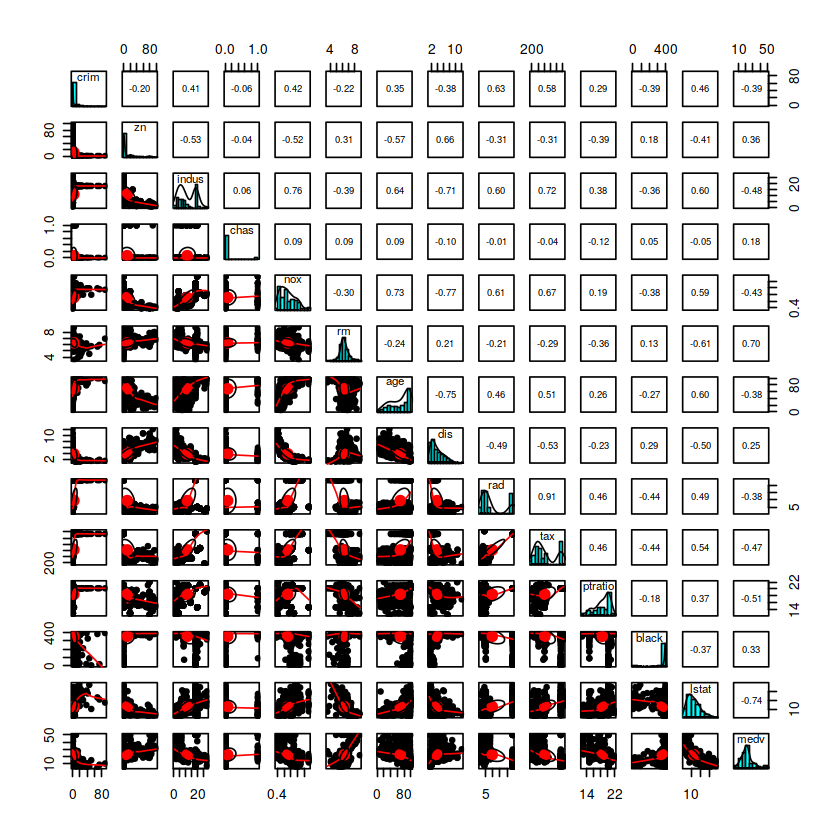

In [4]:
pairs.panels(Boston)

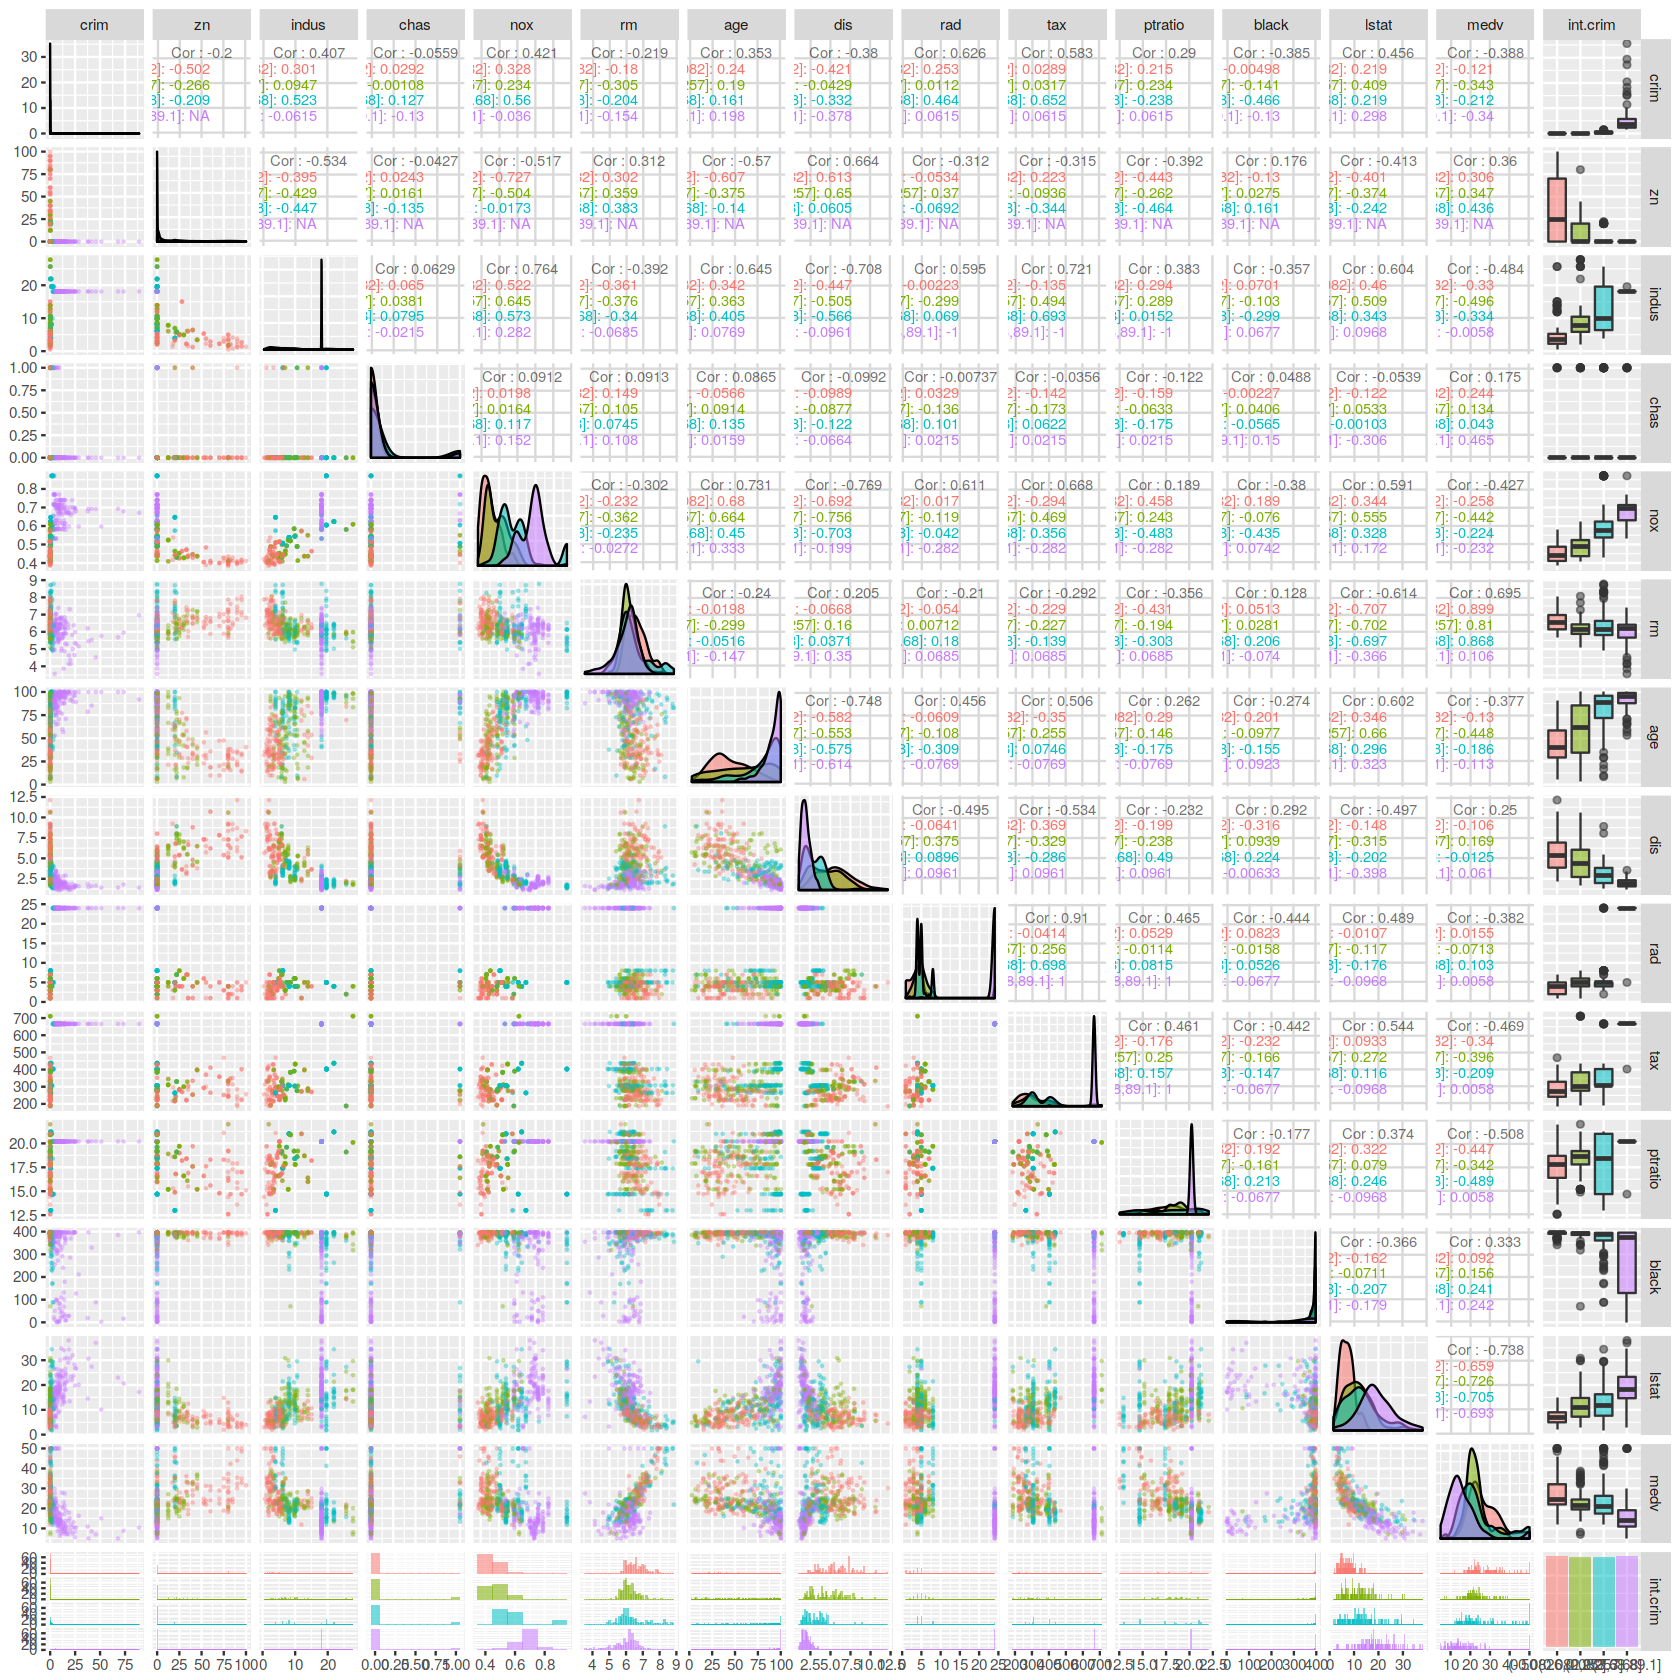

In [5]:
options(repr.plot.width = 14, repr.plot.height = 14)

boston.pairs <- Boston
boston.pairs$int.crim <- quantileCut(boston.pairs$crim, 4)

suppressWarnings(print(
ggpairs(
    boston.pairs, 
    aes(alpha = 0.4, color = int.crim),
    lower = list(
        combo = wrap("facethist", binwidth = 0.1), 
        continuous = wrap("points", alpha = 0.3, size = 0.3)), 
    upper = list(
        continuous = wrap("cor", size = 3)))))

Lower status of population (**lstat**) and average number of rooms per dwelling (**rm**) are strongly correlated with the median value of owner-occupied homes in \$1000s (**medv**). Let’s visualize the correlation with the correlation matrix. 

It seems some features have many constant values. Let’s check this with a heat map of the values.

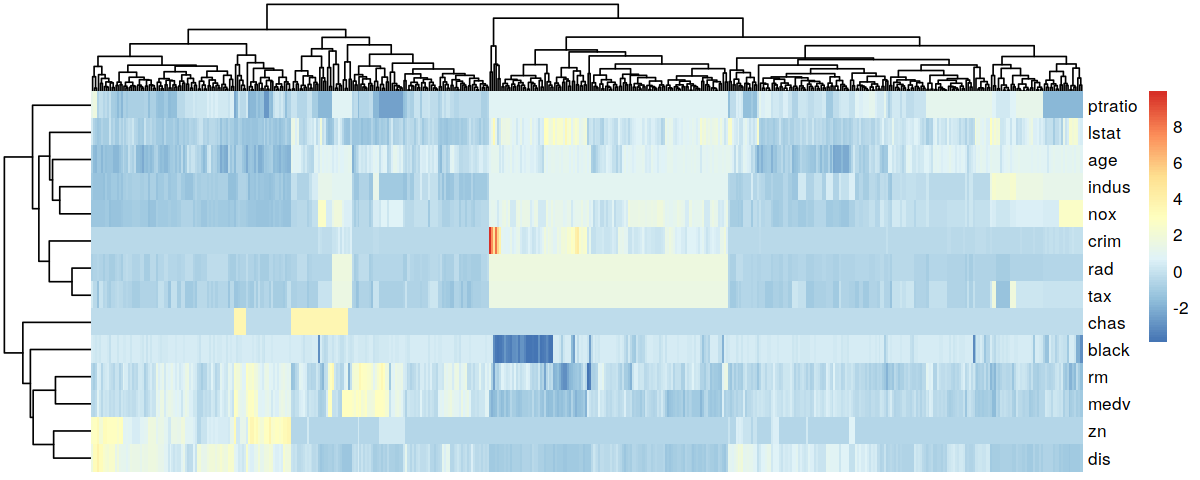

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)

pheatmap(t(scale(Boston)), show_colnames = FALSE)

Indeed, the correlation dendrogram of columns above shows that some features 
have many constant values at the same time, implying the existance of colinear predictors. 

Note how the index of accessibility to radial highways (**rad**) and 
the full-value property-tax rate per \$10,000 (**tax**) have a constant value 
together. The pupil–teacher ration (**ptratio**) also seem to be constant at the same times —
observe the upper dendrogram of rows. However, **ptratio** 
is clustered way after (**rad**, **tax**) were.

Let’s see which values **rad** and **tax** assume.

In [7]:
library("IRdisplay")

display_markdown("##### rad")
summary(Boston$rad)
table(Boston$rad)

display_markdown("##### tax")
summary(Boston$tax)
tax.table <- table(Boston$tax)
tax.table[tax.table > 10]

display_markdown("##### ptratio")
summary(Boston$ptratio)
ptratio.table <- table(Boston$ptratio)
ptratio.table[ptratio.table > 10]

##### rad

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   5.000   9.549  24.000  24.000 


  1   2   3   4   5   6   7   8  24 
 20  24  38 110 115  26  17  24 132 

##### tax

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  187.0   279.0   330.0   408.2   666.0   711.0 


264 277 304 307 384 398 403 437 666 
 12  11  14  40  11  12  30  15 132 

##### ptratio

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.60   17.40   19.05   18.46   20.20   22.00 


  13 14.7 15.2 16.6 17.4 17.8 17.9 18.4 18.6 19.1 19.2 20.2 20.9   21 21.2 
  12   34   13   16   18   23   11   16   17   17   19  140   11   27   15 

It looks like when **rad** is 24, **tax** is 666. Let’s confirm and also get
the values for **ptratio**.

In [8]:
rad.rows <- Boston$rad == 24
tax.rows <- Boston$tax == 666
ptratio.rows <- Boston$ptratio == 20.2

cbind(apply(Boston[rad.rows, c("rad", "tax", "ptratio")], 2, summary),
      apply(Boston[tax.rows, c("rad", "tax", "ptratio")], 2, summary),
      apply(Boston[ptratio.rows, c("rad", "tax", "ptratio")], 2, summary))

,rad,tax,ptratio,rad,tax,ptratio,rad,tax,ptratio
Min.,24,666,20.2,24,666,20.2,5.00000,224.0000,20.2
1st Qu.,24,666,20.2,24,666,20.2,24.00000,666.0000,20.2
Median,24,666,20.2,24,666,20.2,24.00000,666.0000,20.2
Mean,24,666,20.2,24,666,20.2,22.91429,640.7429,20.2
3rd Qu.,24,666,20.2,24,666,20.2,24.00000,666.0000,20.2
Max.,24,666,20.2,24,666,20.2,24.00000,666.0000,20.2


So, we know that if **rad** is 24, then **rad** is 666, and the other way around also holds.

We can also say that if **rad** is 24, then **ptratio** is 666, but the back is not true because there is at least a **rad** and **tax** with values 5 and 224 when **ptratio**  is 666.

Now we can have some initial insights (that need to be verified):

Regarding the median house values (**medv**):
- Houses with more rooms (**rm**) are more expensive (**medv**)
- Poorer areas (**lstat**) reduce the price of houses 
- Expensive houses have a lower tax rate, perhaps because the tax is limited to a value.
- The atmospheric chemistry (**nox**) is a measure of nitric oxide (NO) and nitrogen dioxide (NO2) in the area. Industrial areas of town centers can have a higher concentration, which is associated with a reduced price of houses. In fact, the proportion of non-retail business acres per town (**indus**) has a high correlation with **nox**.
- The pupil–teacher ratio by town (**ptarion**) seems to be related with **proportion of residential land zoned**

### Are any of the predictors associated with per capita crime rate?

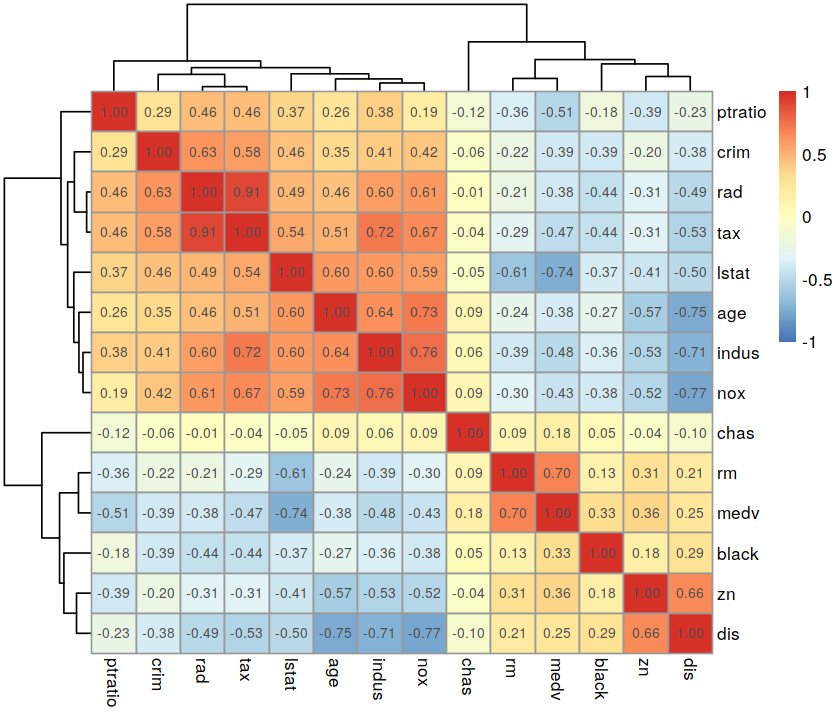

In [9]:
options(repr.plot.width = 7, repr.plot.height = 6)

pheatmap(cor(Boston, use="pairwise.complete.obs"), 
         display_numbers = TRUE,
         breaks = seq(-1, 1, 0.02))

These predictors seem to be related to the crime rate:

- Positive, higher than 0.3: **rad, tax, lstat, age, indus, nox**
- Negative, lower than -0.3: **medv, black, dis**

## Linear Regression

### Simple Linear Regression

In [10]:
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


Let’s try to predict **medv** using the others as predictors.

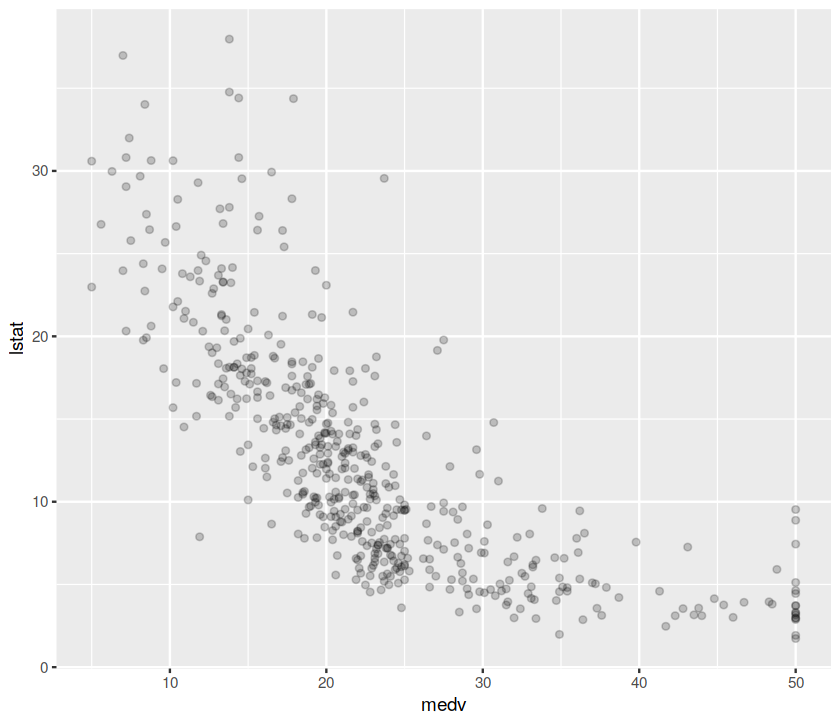

In [11]:
ggplot(Boston, aes(medv, lstat)) + geom_point(alpha = 0.2)

In [12]:
lm.fit <- lm(medv ~ lstat, data = Boston)
summary(lm.fit)


Call:
lm(formula = medv ~ lstat, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.168  -3.990  -1.318   2.034  24.500 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.55384    0.56263   61.41   <2e-16 ***
lstat       -0.95005    0.03873  -24.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.216 on 504 degrees of freedom
Multiple R-squared:  0.5441,	Adjusted R-squared:  0.5432 
F-statistic: 601.6 on 1 and 504 DF,  p-value: < 2.2e-16


In [13]:
coef(lm.fit)

(Intercept)       lstat 
 34.5538409  -0.9500494

Confidence interval of the coefficient estimates.

In [14]:
confint(lm.fit)

,2.5 %,97.5 %
(Intercept),33.448457,35.6592247
lstat,-1.026148,-0.8739505


In [15]:
display_markdown("#### Confidence Intervals")
predict(lm.fit, data.frame(lstat = c(5, 10, 15)), interval = "confidence")
display_markdown("#### Prediction Intervals")
predict(lm.fit, data.frame(lstat = c(5, 10, 15)), interval = "prediction")

#### Confidence Intervals

,fit,lwr,upr
1,29.80359,29.00741,30.59978
2,25.05335,24.47413,25.63256
3,20.30310,19.73159,20.87461


#### Prediction Intervals

,fit,lwr,upr
1,29.80359,17.565675,42.04151
2,25.05335,12.827626,37.27907
3,20.30310,8.077742,32.52846


To remember, *prediction intervals* are always wider than the 
*confidence intervals*.

Remember we are approximating $y = f(x) + \epsilon$. Thus:

- **Confidence interval**: quantify the uncertainty of the surrounding the 
    *average*.  We interpret it as 95% of the confidence intervals will contain
    the actual $f(X)$.
- **Prediction interval**: even if we knew the actual $f(X)$, how much the
    prediction would vary? This is the prediction error plus the irreducible
    error $\epsilon$. We interpret it as 95% of the prediction intervals will contain 
    $y$.


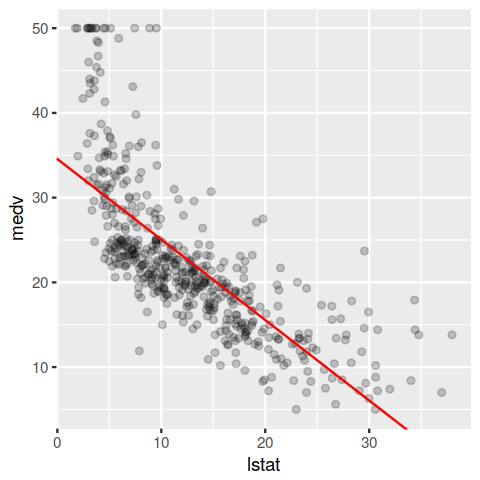

In [16]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(Boston, aes(lstat, medv)) + 
    geom_point(alpha = 0.2) +
    geom_abline(
        intercept = coef(lm.fit)[1],
        slope = coef(lm.fit)[2],
        colour = "red")

This looks somewhat non-linear.

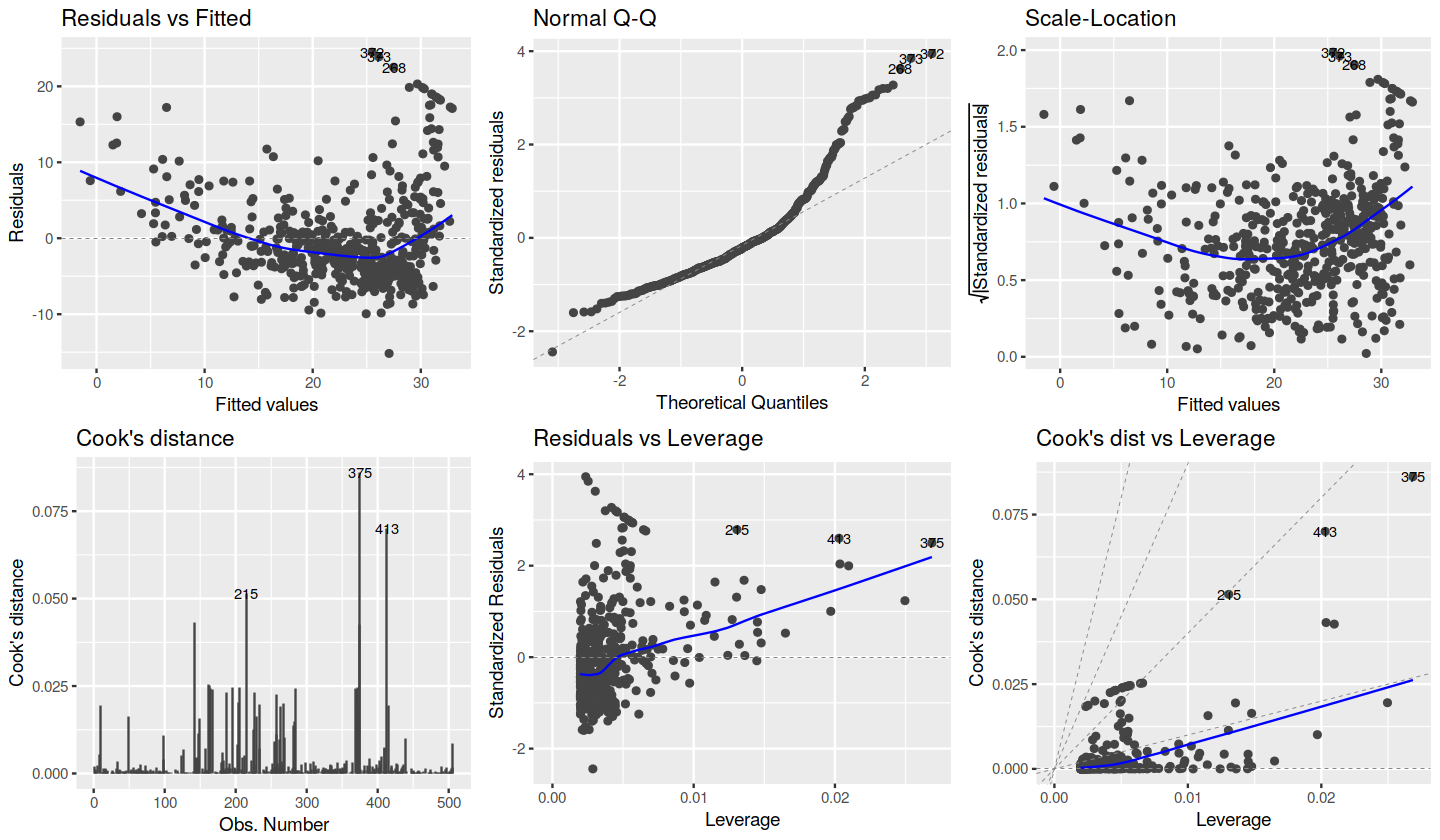

In [17]:
library("ggfortify")

options(repr.plot.width = 12, repr.plot.height = 7)

autoplot(lm.fit, which = 1:6, ncol = 3, label.size = 3)

- **Residuals × Fitted**: Evidence of a non-linear relationship
- **Normal Q–Q**: The Q–Q plot of the residuals shows that they are not normally distributed, otherwise would follow a straight line.
- **Scale–Location**: This plot is useful to check for homoscedasticity. In this case, the residuals show a heterocedasticity spread, because the are concentrated in some values and more spread in others.
- **Residuals × Leverage**: This plot helps find influential observations, which can be outliers. There are not visible outliers in this data.

In [18]:
Boston <- Boston[-c(215, 375, 413), ]

### Multiple Linear Regression

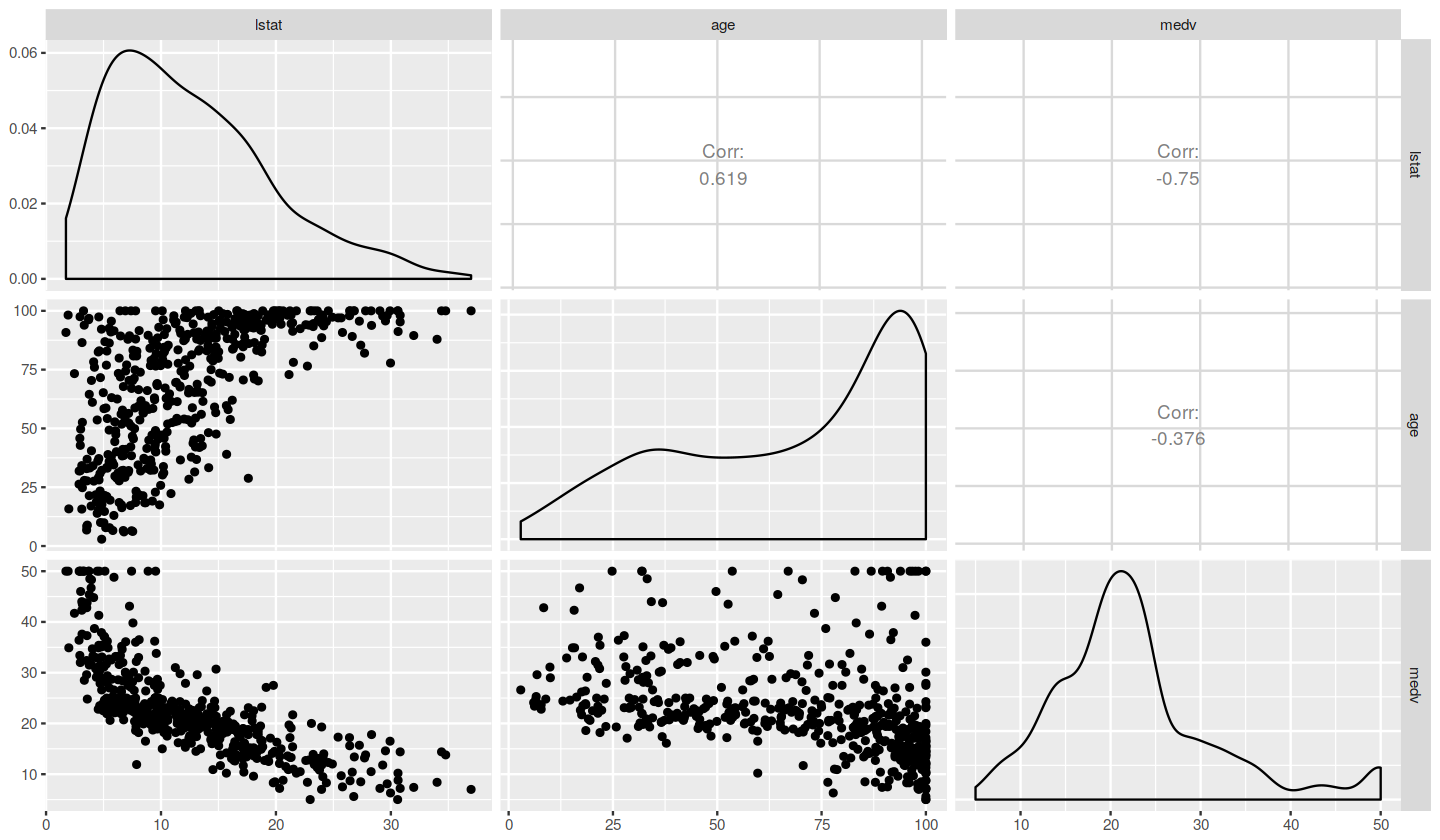

In [19]:
ggpairs(Boston[, c("lstat", "age", "medv")])

In [20]:
lm.fit <- lm(medv ~ lstat + age, data = Boston)
summary(lm.fit)


Call:
lm(formula = medv ~ lstat + age, data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-16.383  -3.932  -1.222   2.146  22.648 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 33.23894    0.71606  46.419  < 2e-16 ***
lstat       -1.10914    0.04909 -22.594  < 2e-16 ***
age          0.04683    0.01219   3.841 0.000138 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.017 on 500 degrees of freedom
Multiple R-squared:  0.5752,	Adjusted R-squared:  0.5735 
F-statistic: 338.6 on 2 and 500 DF,  p-value: < 2.2e-16


In [21]:
lm.fit <- lm(medv ~ ., data = Boston)
summary(lm.fit)


Call:
lm(formula = medv ~ ., data = Boston)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.4190  -2.6954  -0.4505   1.8276  25.6627 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  33.219415   5.008945   6.632 8.79e-11 ***
crim         -0.103924   0.031992  -3.248 0.001240 ** 
zn            0.045278   0.013370   3.387 0.000765 ***
indus         0.029044   0.059858   0.485 0.627743    
chas          2.621483   0.838160   3.128 0.001867 ** 
nox         -15.587064   3.742207  -4.165 3.68e-05 ***
rm            3.909994   0.408725   9.566  < 2e-16 ***
age           0.009027   0.013140   0.687 0.492427    
dis          -1.353187   0.195346  -6.927 1.36e-11 ***
rad           0.289294   0.064626   4.476 9.45e-06 ***
tax          -0.011827   0.003660  -3.232 0.001314 ** 
ptratio      -0.914783   0.127468  -7.177 2.67e-12 ***
black         0.009935   0.002645   3.755 0.000194 ***
lstat        -0.587086   0.050944 -11.524  < 2e-16 ***
---
Signif.

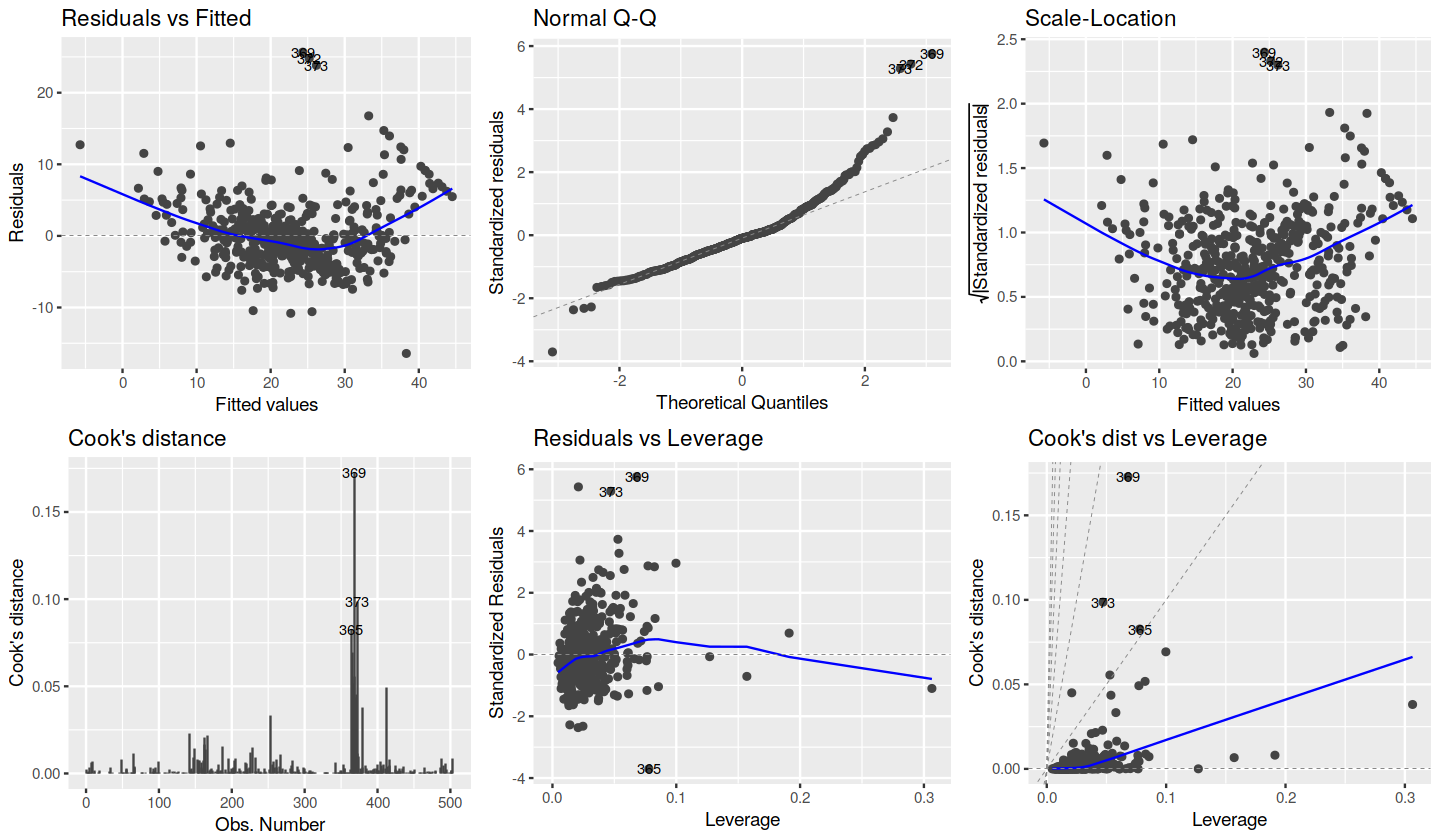

In [22]:
options(repr.plot.width = 12, repr.plot.height = 7)

autoplot(lm.fit, which = 1:6, ncol = 3, label.size = 3)

### Non-linear Transformations of the Predictors

In [23]:
lm.fit2 <- lm(medv ~ lstat + I(lstat^2), data = Boston)
summary(lm.fit2)


Call:
lm(formula = medv ~ lstat + I(lstat^2), data = Boston)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2966  -3.8334  -0.5395   2.3280  25.3994 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 42.812281   0.891027   48.05   <2e-16 ***
lstat       -2.319315   0.129298  -17.94   <2e-16 ***
I(lstat^2)   0.042846   0.004016   10.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.51 on 500 degrees of freedom
Multiple R-squared:  0.6438,	Adjusted R-squared:  0.6423 
F-statistic: 451.8 on 2 and 500 DF,  p-value: < 2.2e-16


Hypothesis test. Null hypothesis is that the `lm.fit2` fits the data equally well as `lm.fit`. 
The alternative hypethesis is that the `lm.fit2` is superior.

In [24]:
lm.fit <- lm(medv ~ lstat, data = Boston)
anova(lm.fit, lm.fit2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
501,18636.72,NA,NA,NA,NA
500,15181.46,1,3455.26,113.7987,4.471666e-24


The **F** is 135 with a *p* pratically zero. We reject the null hypothesis.
Thus, the **lstat²** improved a lot the model.

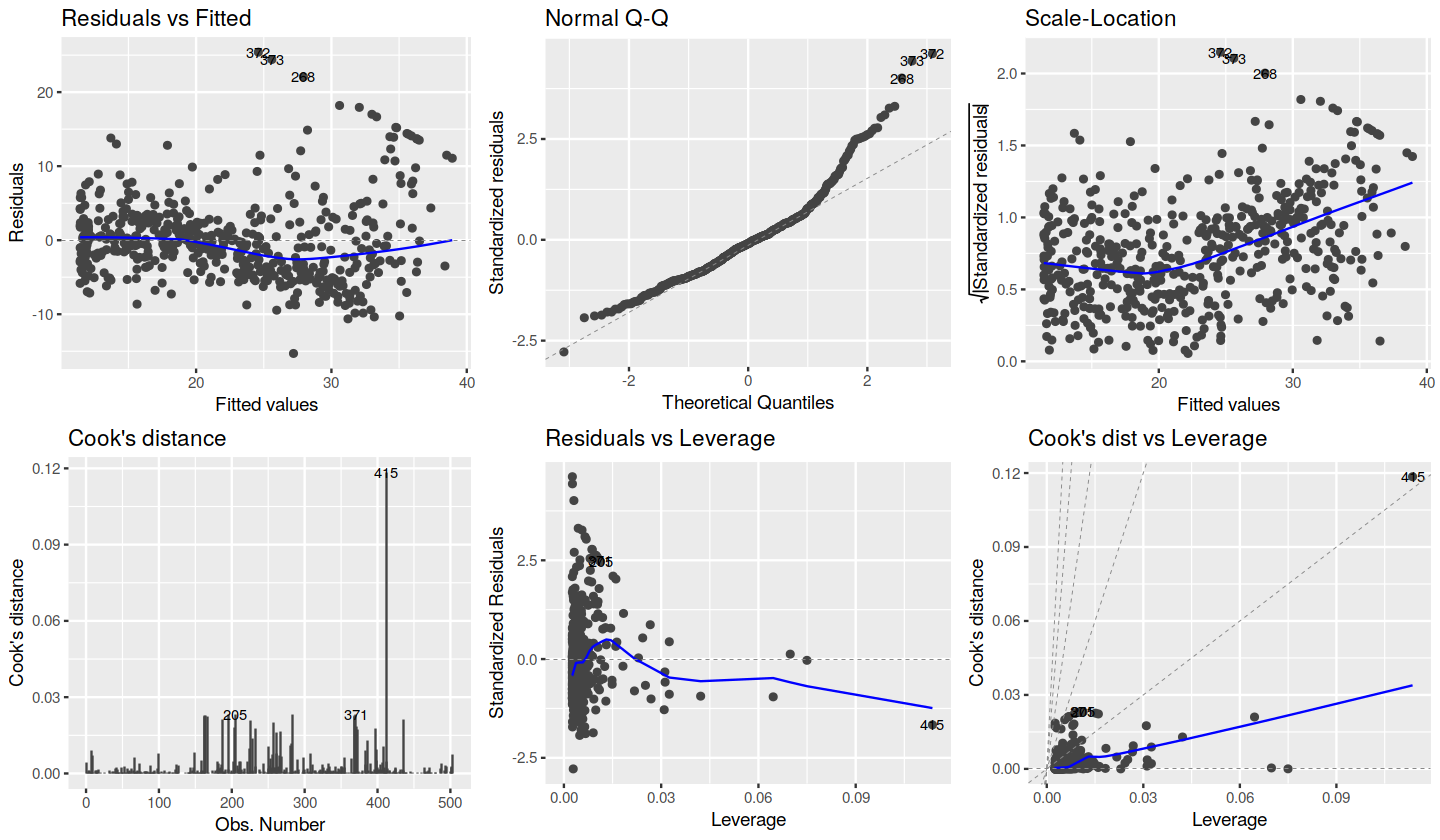

In [25]:
autoplot(lm.fit2, which = 1:6, ncol = 3, label.size = 3)

In [26]:
library(parallel)
library(doParallel)

fitControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 10,
    verboseIter = TRUE,
    returnResamp = "all")

rrfFit <- train(crim ~ ., 
                data = Boston,
                method = "ranger",
                tuneLength = 10, 
                trControl = fitControl,
                num.trees = 700,
                importance = "permutation")

Loading required package: foreach
Loading required package: iterators
Loading required package: e1071
Loading required package: ranger


+ Fold1.Rep01: mtry= 2 
- Fold1.Rep01: mtry= 2 
+ Fold1.Rep01: mtry= 3 
- Fold1.Rep01: mtry= 3 
+ Fold1.Rep01: mtry= 4 
- Fold1.Rep01: mtry= 4 
+ Fold1.Rep01: mtry= 5 
- Fold1.Rep01: mtry= 5 
+ Fold1.Rep01: mtry= 6 
- Fold1.Rep01: mtry= 6 
+ Fold1.Rep01: mtry= 8 
- Fold1.Rep01: mtry= 8 
+ Fold1.Rep01: mtry= 9 
- Fold1.Rep01: mtry= 9 
+ Fold1.Rep01: mtry=10 
- Fold1.Rep01: mtry=10 
+ Fold1.Rep01: mtry=11 
- Fold1.Rep01: mtry=11 
+ Fold1.Rep01: mtry=13 
- Fold1.Rep01: mtry=13 
+ Fold2.Rep01: mtry= 2 
- Fold2.Rep01: mtry= 2 
+ Fold2.Rep01: mtry= 3 
- Fold2.Rep01: mtry= 3 
+ Fold2.Rep01: mtry= 4 
- Fold2.Rep01: mtry= 4 
+ Fold2.Rep01: mtry= 5 
- Fold2.Rep01: mtry= 5 
+ Fold2.Rep01: mtry= 6 
- Fold2.Rep01: mtry= 6 
+ Fold2.Rep01: mtry= 8 
- Fold2.Rep01: mtry= 8 
+ Fold2.Rep01: mtry= 9 
- Fold2.Rep01: mtry= 9 
+ Fold2.Rep01: mtry=10 
- Fold2.Rep01: mtry=10 
+ Fold2.Rep01: mtry=11 
- Fold2.Rep01: mtry=11 
+ Fold2.Rep01: mtry=13 
- Fold2.Rep01: mtry=13 
+ Fold3.Rep01: mtry= 2 
- Fold3.Rep01: m